Run this line to install `RobustiPy` from GitHub.

In [1]:
%pip install git+https://github.com/robustipy/robustipy.git

  Cloning https://github.com/robustipy/robustipy.git to /tmp/pip-req-build-v120b3ur
  Running command git clone --filter=blob:none --quiet https://github.com/robustipy/robustipy.git /tmp/pip-req-build-v120b3ur
  Resolved https://github.com/robustipy/robustipy.git to commit feef1700f34ae4a2de4c2538219687d098127d33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for robustipy: filename=robustipy-1.0b2-py3-none-any.whl size=34547 sha256=dbb3c66d387a7bad25619abf96b44dfe6d0b006dece24e35259887ff1ed23804
  Stored in directory: /tmp/pip-ephem-wheel-cache-qvz7ahfu/wheels/6d/3d/9c/4b6315b552677fef7d22d97416eb6b7122d1d51b9cf7b84e97
Successfully built robustipy
^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
from robustipy.models import OLSRobust
import pandas as pd
import matplotlib.pyplot as plt

# Data generation
Let's generated some data based on some covariance values and totally made-up coeficients.

Let's first create the fake covariance matrix and the fake coeficients. You can change and play around with this values to see how the final dataset changes. Note also that we are implicitely assuming the data generation process is a linear process.

In [2]:
beta1 = np.array([.2, .5, -.4, -.7, .2])
beta2 = np.array([.3, .4, -.35, -.8, .2])
beta3 = np.array([.15, .6, -.45, -.1, .2])
beta4= np.array([.4, .3, -.5, -.1, .2])

cov_matrix = np.array([[1, 0.7, 0.5, 0.7, 0.1],
                       [0.7, 1, 0.5, 0.3, 0.2],
                       [0.5, 0.5, 1, 0.4, 0.2],
                       [0.7, 0.3, 0.4, 1, 0.6],
                       [0.1, 0.2, 0.2, 0.6, 1]])

Now let's define the final sample size of our generated dataset. We will start with 1000, but we can change this to any number.

In [3]:
num_samples = 1000

We now can create a synthetic dataset with fake data that has the relationships that we want to test.

In [4]:
mean_vector = np.zeros(5)
X = np.random.multivariate_normal(mean=mean_vector, cov=cov_matrix, size=num_samples)
X_i = np.column_stack((np.ones(num_samples), X[:, 0:4]))
errors = np.random.normal(loc=0.0, scale=1.0, size=num_samples)
Y1 = np.dot(X_i, beta1) + errors
np_data = np.column_stack((Y1, X))
data = pd.DataFrame(np_data, columns=['y1','x1', 'z1', 'z2', 'z3', 'z4'])
data.head()

,y1,x1,z1,z2,z3,z4
0,1.060525,0.003317,-0.134327,-1.138872,0.149679,0.047398
1,-0.014906,-0.700321,-0.896032,0.193238,0.308186,0.292967
2,1.222603,0.495835,-0.708378,0.210722,1.353762,0.089078
3,0.091848,0.483201,0.681148,0.745978,0.576531,1.391900
4,-0.515136,-0.366024,0.168026,-0.506117,-1.611236,-1.958087


Let's plot the correlation of our variables.

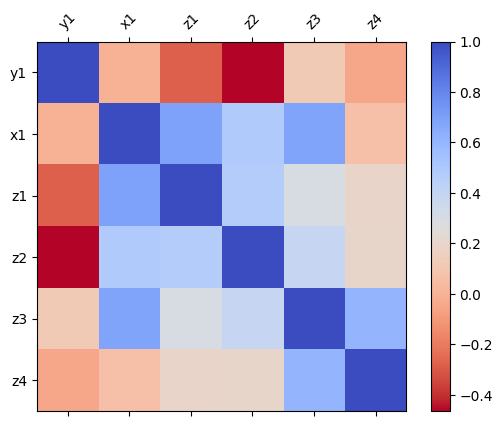

In [5]:
labels = data.columns
fig, ax = plt.subplots()
cax = ax.matshow(data.corr(), cmap='coolwarm_r')

fig.colorbar(cax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(rotation=45)

plt.show()

## Testing RobustiPy with this simulated data

In this case we will use the simple OLSRobust class to test all possible multiple linear regressions, giving this setting. Remember, our coeficient of interest is always `y1~x1`. The variation in the plot d (the specification curve) represent the variation of this relationship depending of which covariates are included in the model.

Just to test it's functionality, we are visualizing specification `z1, z2`, `z1` and `z2`. This means that we are visualizing models `y1~x1+z1+z2`, `y1~x1+z1`, `y1~x1+z2`.

Output()

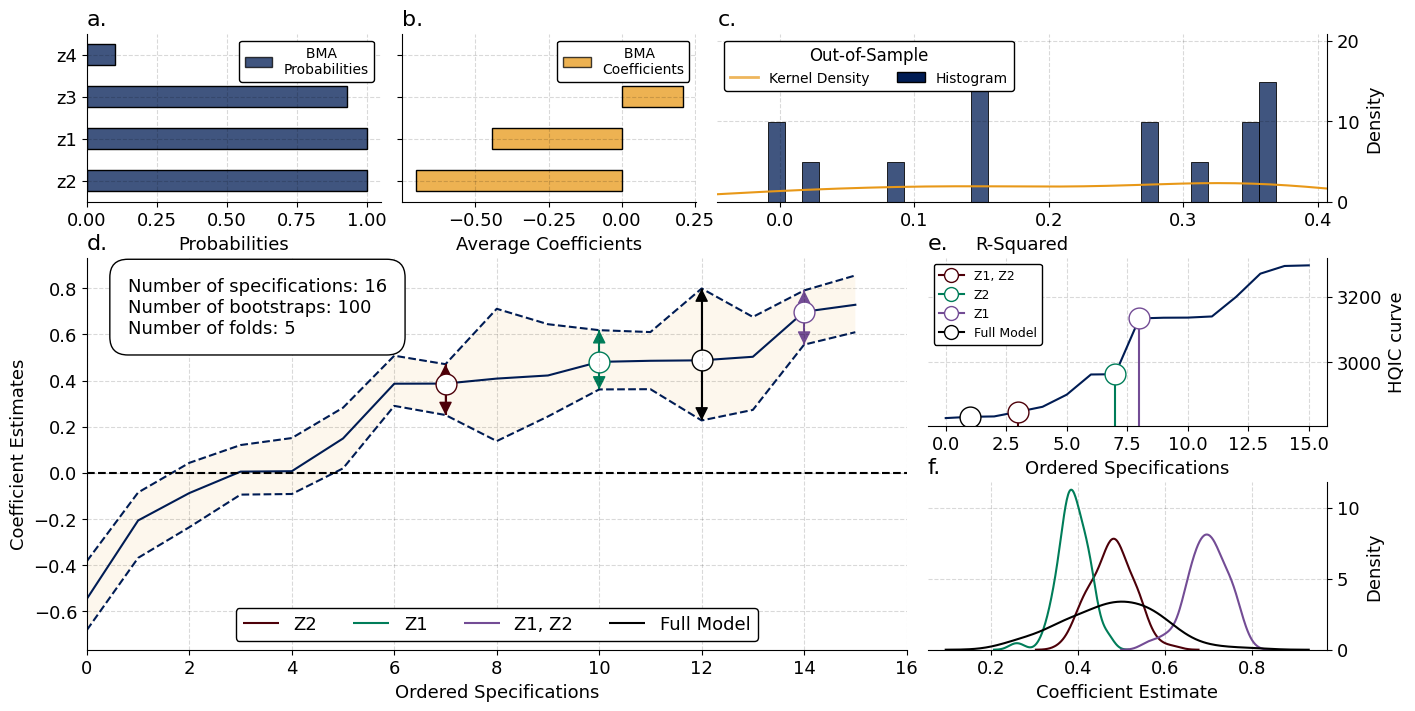

In [6]:
y = ['y1'] # input names must always be enclosed in a list.
x = ['x1']
c= ['z1', 'z2', 'z3', 'z4']

sim1 = OLSRobust(y=y, x=x, data=data)
sim1.fit(controls=c, draws=100)
sim1_results = sim1.get_results()

sim1_results.plot(specs=[['z1', 'z2'], ['z1'], ['z2']], ic='hqic', figsize=(16, 8))

Finally lets take a look at the summary of our model.

In [7]:
sim1_results.summary()

1. Model Summary
Model: OLS Robust
Dependent variable: y1
Independent variable: x1
Number of possible controls: 4
Number of draws: 100
Number of folds: 5
Number of specifications: 16
2.Model Robustness Metrics
2.1 Inference Metrics
------------------------------------------------------------------------------------------------------------
Mean beta: 0.27
Significant portion of beta: 0.81
Positive portion of beta: 0.81
Positive and Significant portion of beta: 0.69
Min AIC: 4811.386864808601, Specs: ['z1', 'z4', 'z2', 'z3']
Min BIC: 2845.938304081989, Specs: ['z1', 'z2', 'z3']
Min HQIC: 2830.7259750262388, Specs: ['z1', 'z2', 'z3']
------------------------------------------------------------------------------------------------------------
2.2 Averaged Out-Of-Sample Metrics (r-squared)
------------------------------------------------------------------------------------------------------------
Max: 0.3690695029923748, Specs: ['z1', 'z2', 'z3'] 
Min: -0.008473985334440215, Specs: [] 
Mean:

It seems that ome model stands out: `y1~x1+z1+z2+z3`. Lets plot it:

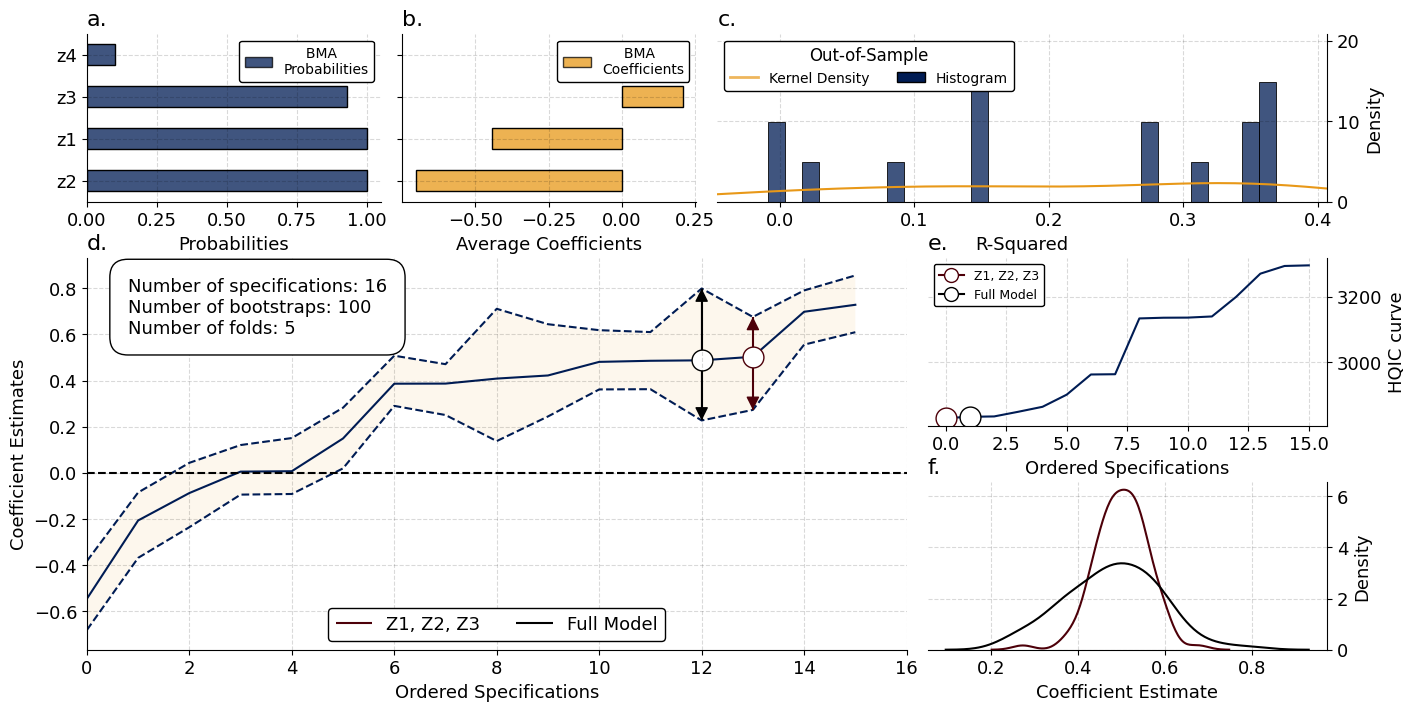

In [8]:
sim1_results.plot(specs=[['z1', 'z2', 'z3']], ic='hqic', figsize=(16, 8))